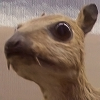

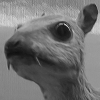

In [1]:
from PIL import Image
from scipy.ndimage import convolve
from scipy.linalg import toeplitz
import numpy as np
import math
import time

img = Image.open("input-img.png")
display(img)
grayimg = img.convert('L')
display(grayimg)
grayimg = np.asarray(grayimg)

## Przesuwanie filtra po obrazku

In [2]:
def convolution(image, matrices, stride):
    """
    Function which applies convolution on an image by moving the kernel over the image.
    Parameters:
        - grayscale or RGB image, in a form of a numpy array
        - a list of kernels for convolution, in a form of numpy arrays
        - stride
    Result:
        - a list with multiple result images, one for each kernel
    """
    allResults = []
    for matrix in matrices:
        newShape = ((image.shape[0]-matrix.shape[0]+1)//stride,(image.shape[1]-matrix.shape[1]+1)//stride)
        result = np.zeros(newShape)

        for pos, im in np.ndenumerate(result):
            for off, mat in np.ndenumerate(matrix):
                curPos = (pos[0]*stride+off[0], pos[1]*stride+off[1])
                if len(off)>2:
                    curPos = (curPos[0],curPos[1],off[2])

                result[pos] += image[curPos]*mat
        allResults.append(result)
    return allResults

graymatrix = [np.array([
    [0,1,0],
    [1,-4,1],
    [0,1,0]
])/16,np.array([
    [1,1,1],
    [1,1,1],
    [1,1,1]
])/9]

### Czarno-biały obrazek, wiele filtrów

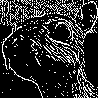

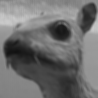

In [3]:
conv = convolution(grayimg, graymatrix, 1)

display(Image.fromarray(conv[0].astype(np.uint8), 'L'))
display(Image.fromarray(conv[1].astype(np.uint8), 'L'))

**Wbudowana funkcja dla porównania**

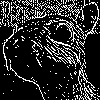

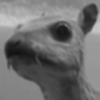

In [4]:
conv0 = convolve(np.asarray(grayimg), graymatrix[0])
display(Image.fromarray(conv0.astype(np.uint8), 'L'))
conv1 = convolve(np.asarray(grayimg), graymatrix[1])
display(Image.fromarray(conv1.astype(np.uint8), 'L'))

### Kolorowy obrazek i stride

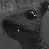

In [5]:
matrix = [np.array([[
    [0,9,0],
    [9,-36,9],
    [0,9,0]
],[
    [0,0,0],
    [0,0,0],
    [0,0,0]
],[
    [1,1,1],
    [1,1,1],
    [1,1,1]
]])/18]

conv = convolution(np.asarray(img), matrix, 2)
display(Image.fromarray(conv[0].astype(np.uint8), 'L'))

## Mnożenie macierzy

In [6]:
def convolution_multiplication(image, matrices):
    """
    Function which applies convolution on an image by matrix multiplication.
    Parameters:
        - grayscale image, in a form of a numpy array
        - a list of kernels for convolution, in a form of numpy arrays
    Result:
        - a list with multiple result images, one for each kernel
    """
    allResults = []
    vector_image = image[::-1].reshape((1, image.shape[0]*image.shape[1]))[0]
    for matrix in matrices:
        # Padding the kernel
        paddedMatrix = np.zeros((image.shape[0]+matrix.shape[0]-1,image.shape[1]+matrix.shape[1]-1))
        paddedMatrix[-matrix.shape[0]:,:matrix.shape[1]] = matrix

        # Generating teoplitz matrices
        teo_matrices = []
        for i in range(paddedMatrix.shape[0]-1,-1,-1):
            first_row = np.r_[paddedMatrix[i,0], np.zeros(image.shape[0] - 1, dtype=int)]
            teo_matrices.append(toeplitz(paddedMatrix[i,:], first_row))

        # Putting them together
        first_col = range(1, paddedMatrix.shape[0]+1)
        first_row = np.r_[first_col[0], np.zeros(image.shape[0]-1, dtype=int)]
        big_matrix_plan = toeplitz(first_col, first_row)

        teo_width = teo_matrices[0].shape[0]
        teo_height = teo_matrices[0].shape[1]
        big_matrix = np.zeros((teo_width*big_matrix_plan.shape[0],teo_height*big_matrix_plan.shape[1]))

        for pos, val in np.ndenumerate(big_matrix_plan):
            if val == 0:
                continue
            big_matrix[pos[0]*teo_width:(pos[0]+1)*teo_width,pos[1]*teo_height:(pos[1]+1)*teo_height] = teo_matrices[val-1]

        # Multiplication
        result = np.matmul(big_matrix, vector_image)
        result = result.reshape(paddedMatrix.shape)[::-1]
        allResults.append(result)
    return allResults

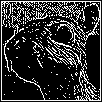

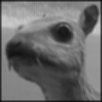

In [7]:
conv = convolution_multiplication(grayimg, graymatrix)

display(Image.fromarray(conv[0].astype(np.uint8), 'L'))
display(Image.fromarray(conv[1].astype(np.uint8), 'L'))

## Porównanie

In [8]:
timestart = time.time()
conv = convolution(grayimg, graymatrix, 1)
timend = time.time()
print("Przesuwanie filtra: ",timend-timestart)

timestart = time.time()
conv = convolution_multiplication(grayimg, graymatrix)
timend = time.time()
print("Mnożenie macierzy: ",timend-timestart)

Przesuwanie filtra:  0.5424914360046387
Mnożenie macierzy:  0.5354883670806885


Czasy obu tych metod są dosyć podobne, zatem nie widać przewagi żadnej z nich. Jednak implementacja wykorzystująca mnożenie macierzy jest zdecydowanie bardziej złożona, co może się przełożyć na zwiększony czas debugowania problemów w kodzie. Dlatego w tym wypadku przesuwanie filtra wydaje się być lepszym rozwiązaniem.